In [5]:

import cv2
import numpy as np
from skimage import img_as_ubyte, io
from skimage.color import rgb2gray
from skimage.filters import gaussian, median
from skimage.morphology import disk
import os
import glob
from skimage import io  # or you can use PIL from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers, models
import pandas as pd 


In [6]:

def preprocess_image(image_path):
    # Load image and convert to grayscale
    image_rgb = io.imread(image_path)
    image_gray = rgb2gray(image_rgb)
    
    # Convert to 8-bit unsigned integer format
    image_gray = img_as_ubyte(image_gray)
    
    # Apply Gaussian filter to reduce noise
    image_filtered = gaussian(image_gray, sigma=1.0)
    
    # Apply Median filter for further noise reduction
    image_filtered = median(image_filtered, disk(3))
    
    return image_filtered

# Example usage


parent_directory = 'Volunteers Data'

# Use glob to get all image file paths in all subdirectories
imgPath = glob.glob(os.path.join(parent_directory, '**', '*.jpg'), recursive=True)  # You can adjust the file type

preprocess = []
for img in imgPath:
    preprocess.append(preprocess_image(img))
    print(f"{img} =====>{preprocess_image(img)}")

Volunteers Data\MADAM REHANA\hand (after 15 days).jpg =====>[[0.66633486 0.66592744 0.66452498 ... 0.7041003  0.71336366 0.71497221]
 [0.66592744 0.66521122 0.66452498 ... 0.69860104 0.7041003  0.70796372]
 [0.66592744 0.66502621 0.66452498 ... 0.69435979 0.69860104 0.70064787]
 ...
 [0.67087996 0.67101328 0.67154911 ... 0.64846644 0.64825474 0.64749917]
 [0.67166918 0.67166918 0.67178778 ... 0.64999612 0.64942548 0.64844369]
 [0.67247173 0.67178778 0.67178778 ... 0.65003148 0.64981975 0.64981975]]
Volunteers Data\MADAM REHANA\hand (after 35 days).jpg =====>[[0.69587682 0.69587682 0.69587682 ... 0.73867533 0.73910312 0.73910312]
 [0.66998925 0.67687036 0.68321014 ... 0.73838502 0.73867533 0.73910312]
 [0.66331333 0.6634241  0.66938392 ... 0.73838502 0.73867533 0.73910312]
 ...
 [0.71099111 0.71231781 0.71245282 ... 0.73549058 0.75368333 0.76106014]
 [0.71343081 0.71343081 0.71291186 ... 0.75476062 0.76106014 0.76817038]
 [0.71439264 0.71385318 0.71343081 ... 0.76106014 0.76817038 0.782

In [ ]:
from skimage.measure import shannon_entropy
from sklearn.feature_extraction import image
preprocess[0]

flattened_images = []
for prep in preprocess:
    flattened_images.append(prep.flatten())  # (86, 480*640))

# Create a DataFrame
df = pd.DataFrame(flattened_images)

# Add the image names as a new column
df['image_name'] = imgPath
df.to_csv('data.csv',index=False)



In [ ]:
df.head()

In [41]:
import numpy as np
from skimage.measure import shannon_entropy
from sklearn.feature_extraction import image as sklearn_image
from skimage.transform import downscale_local_mean
from multiprocessing import Pool, cpu_count

def extract_texture_features(image, block_size=(32, 32), downscale_factor=2):
    # Downsample the image to reduce processing time (optional)
    if downscale_factor > 1:
        image = downscale_local_mean(image, (downscale_factor, downscale_factor))
    
    # Ensure the image is 2D 
    if len(image.shape) != 2:
        raise ValueError("Input image must be a 2D array (grayscale image).")
    
    # Extract patches from the image 
    patches = sklearn_image.extract_patches_2d(image, block_size)
    
    # Parallelize the entropy calculation using multiprocessing
    with Pool(cpu_count()) as pool:
        entropy_values = pool.map(shannon_entropy, patches)
    
    return np.array(entropy_values)


In [22]:

# Example usage:
texture_features = []

# Assuming `flatten_features` is a list or array of 2D images
for features in preprocess:
    if len(features.shape) == 2:  # Check if the feature is a 2D array
        texture_features.append(extract_texture_features(features))
    else:
        print("Skipping: Feature is not a 2D image.")

# Convert list of texture features to a numpy array
texture_features = np.array(texture_features)


In [ ]:
df.head()

In [45]:
from sklearn.decomposition import PCA

def reduce_features_with_pca(features, n_components=10):
    # Ensure features are a 2D array
    if features.ndim == 1:
        features = features.reshape(-1, 1)
    
    # Determine the maximum possible n_components
    max_components = min(features.shape)
    
    if n_components is None or n_components > max_components:
        n_components = max_components
    
    # Apply PCA
    pca = PCA(n_components=n_components)
    reduced_features = pca.fit_transform(features)
    return reduced_features


In [ ]:

# Example usage
reduced_features = reduce_features_with_pca(texture_features)
print(reduced_features)


In [ ]:
df = pd.DataFrame(reduced_features)
df['image_name'] = imgPath

In [ ]:
df.head()

In [ ]:
    from collections import Counter
    import numpy as np
    from minisom import MiniSom
    import pandas as pd
    from scipy.spatial.distance import cdist

    labels = [0, 1]
    # Step 1: Train the SOM
    som = MiniSom(x=2, y=2, input_len=reduced_features.shape[1], sigma=0.3, learning_rate=0.5)
    som.random_weights_init(reduced_features)
    som.train_random(reduced_features, 300)


    bmu_labels = {}

    for feature_vector, label in zip(reduced_features, labels):
        bmu = som.winner(feature_vector)  
        if bmu in bmu_labels:
            bmu_labels[bmu].append(label)
        else:
            bmu_labels[bmu] = [label]

    # Step 3: Assign the most common numeric label to each neuron (BMU)
    neuron_labels = {}
    for bmu, bmu_label_list in bmu_labels.items():
        most_common_label = Counter(bmu_label_list).most_common(1)[0][0]
        neuron_labels[bmu] = most_common_label

    def find_nearest_labeled_bmu(bmu):
        labeled_bmus = np.array(list(neuron_labels.keys()))
        distances = cdist([bmu], labeled_bmus, metric='euclidean')
        nearest_bmu_index = np.argmin(distances)
        nearest_bmu = tuple(labeled_bmus[nearest_bmu_index])
        return neuron_labels[nearest_bmu]

    # Step 4: Classify each feature and assign the predicted numeric label
    def classify_sample(feature_vector):
        bmu = som.winner(feature_vector) 
        return neuron_labels.get(bmu, find_nearest_labeled_bmu(bmu)) 

    predicted_labels = [classify_sample(feature_vector) for feature_vector in reduced_features]

    print(f"The predicted numeric labels for the samples are: {predicted_labels}")

In [38]:
df1 = pd.DataFrame(reduced_features)
df1['predicted_label'] = predicted_labels
df1.to_csv('labeled_features.csv',index=False)

In [ ]:
df.shape

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Load data
df = pd.read_csv('labeled_features.csv')
X = df.iloc[:, :-1].values  # Features (all columns except the last one)
y = df.iloc[:, -1].values   # Labels (the last column)
n_samples, n_features = X.shape

# Function to pad or resize feature vectors to the target size (1024 for 32x32)
def pad_to_square(features, target_size=1024):
    # Pad with zeros if necessary
    padded_features = np.pad(features, (0, target_size - len(features)), mode='constant')
    return padded_features

# Pad each feature vector to 1024 elements (for 32x32 grid)
padded_features = np.array([pad_to_square(f, target_size=1024) for f in X])

# Reshape to (n_samples, 32, 32, 1)
X = padded_features.reshape(n_samples, 32, 32, 1)

print("Reshaped features to:", X.shape)  # Should output (n_samples, 32, 32, 1)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print new image size
image_size = 32
print(f"Image size: {image_size}x{image_size}")


Reshaped features to: (86, 32, 32, 1)
Image size: 32x32


In [2]:
df

,0,1,2,3,4,5,6,7,8,9,predicted_label
0,-0.155382,-0.180570,-0.109889,-0.034136,0.157192,0.045793,-0.051792,0.036267,-0.113291,-0.035653,0
1,0.086319,-0.141318,0.102386,0.254724,-0.080175,-0.054721,-0.058284,-0.012544,-0.097430,-0.109432,1
2,-0.095033,0.069098,-0.052751,0.013302,-0.022223,0.064401,-0.011398,-0.068970,0.122631,0.104037,0
3,0.094548,-0.103798,0.266251,-0.054997,-0.072192,-0.105512,0.010665,-0.136902,-0.079638,0.052371,1
4,-0.174664,0.032897,-0.013120,0.048326,-0.020932,0.002168,0.006266,0.059693,-0.085654,0.038058,0
...,...,...,...,...,...,...,...,...,...,...,...
81,0.546144,0.054171,-0.030473,0.263079,0.239724,0.137508,0.201931,-0.222610,0.114636,0.062295,0
82,0.000798,-0.002693,-0.065212,0.009173,-0.104886,-0.043554,0.008996,-0.104692,-0.021153,-0.007448,0
83,-0.196618,-0.069819,0.037947,0.040552,0.041880,0.010885,-0.014197,0.010732,-0.046791,0.025298,0
84,0.021947,-0.063655,-0.046868,0.006048,-0.035929,0.026771,0.136754,0.047878,0.155872,-0.046510,0


In [8]:
df['image_name'] = imgPath 

In [26]:
test_df =df.query(r'image_name == "Volunteers Data\MADAM REHANA\hand (after 35 days).jpg"')
test_df = test_df.drop(['image_name'], axis=1)
test_df = test_df.drop(['predicted_label'], axis=1)
test_df

s 


<unknown>:1: SyntaxWarning: invalid escape sequence '\M'


,0,1,2,3,4,5,6,7,8,9
1,0.086319,-0.141318,0.102386,0.254724,-0.080175,-0.054721,-0.058284,-0.012544,-0.09743,-0.109432


In [93]:
import numpy as np
import pandas as pd
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split

# Step 1: Load and Prepare Data
df = pd.read_csv('labeled_features.csv')

# Extract features and labels
X = df.iloc[:, :-1].values  # Features (all columns except the last one)
y = df.iloc[:, -1].values   # Labels (the last column)

# Check the shape of the data
n_samples, n_features = X.shape

# Function to pad feature vectors to 900 elements
def pad_to_square(features, target_size=900):
    # Pad with zeros if necessary
    padded_features = np.pad(features, (0, target_size - len(features)), mode='constant')
    return padded_features

# Step 2: Pad each feature vector to 900 elements
padded_features = np.array([pad_to_square(f, target_size=900) for f in X])

# Step 3: Reshape the padded features to (n_samples, 30, 30, 1)
X = padded_features.reshape(n_samples, 30, 30, 1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Define Image Size
image_size = 30

# Step 5: Build the 2D CNN model for binary classification
cnn_model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(image_size, image_size, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Sigmoid activation for binary classification
])

# Step 6: Compile the model using binary_crossentropy as the loss function
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Step 7: Train the model
history = cnn_model.fit(X_train, y_train, epochs=120, batch_size=32, validation_data=(X_test, y_test))

# Step 8: Evaluate the model on test data
test_loss, test_accuracy = cnn_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


Epoch 1/120


C:\Users\arham\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - accuracy: 0.5779 - loss: 0.6927 - val_accuracy: 0.6667 - val_loss: 0.6893
Epoch 2/120
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6707 - loss: 0.6883 - val_accuracy: 0.6667 - val_loss: 0.6803
Epoch 3/120
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6629 - loss: 0.6787 - val_accuracy: 0.6667 - val_loss: 0.6653
Epoch 4/120
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6707 - loss: 0.6627 - val_accuracy: 0.6667 - val_loss: 0.6489
Epoch 5/120
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6434 - loss: 0.6550 - val_accuracy: 0.6667 - val_loss: 0.6379
Epoch 6/120
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6707 - loss: 0.6382 - val_accuracy: 0.6667 - val_loss: 0.6421
Epoch 7/120
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6629 - loss: 0.6496 - val_accuracy: 0.6667 - val_loss: 0.6624
Epoch 8/120
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6590 - loss: 0.6741 - val_accuracy: 0.6667 - val_loss: 0.6702
Epo

In [94]:
y_pred = cnn_model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


In [102]:
h = [np.round(s) for s in y_pred]

In [103]:
h

[array([1.], dtype=float32),
 array([0.], dtype=float32),
 array([0.], dtype=float32),
 array([0.], dtype=float32),
 array([0.], dtype=float32),
 array([1.], dtype=float32),
 array([0.], dtype=float32),
 array([1.], dtype=float32),
 array([0.], dtype=float32),
 array([0.], dtype=float32),
 array([0.], dtype=float32),
 array([0.], dtype=float32),
 array([1.], dtype=float32),
 array([0.], dtype=float32),
 array([1.], dtype=float32),
 array([0.], dtype=float32),
 array([0.], dtype=float32),
 array([1.], dtype=float32)]

In [42]:
img_path = "Volunteers Data\MADAM REHANA\hand (after 35 days).jpg"
prep = preprocess_image(img_path)

features = extract_texture_features(prep)


<>:1: SyntaxWarning: invalid escape sequence '\M'
<>:1: SyntaxWarning: invalid escape sequence '\M'
C:\Users\arham\AppData\Local\Temp\ipykernel_14248\486146898.py:1: SyntaxWarning: invalid escape sequence '\M'
  img_path = "Volunteers Data\MADAM REHANA\hand (after 35 days).jpg"


In [90]:
reduced_feat = reduce_features_with_pca(features)
reduced_feat.shape
X[0].shape

(30, 30, 1)

In [49]:
X_test.shape

(18, 30, 30, 1)

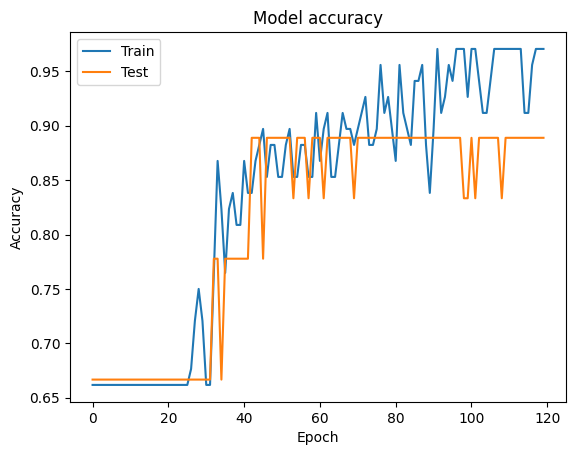

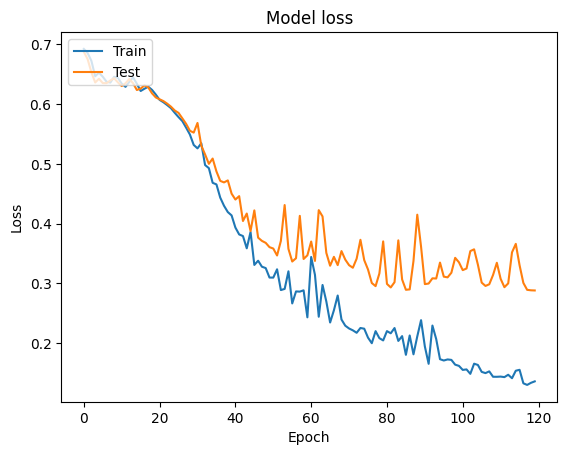

In [80]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
